In [1]:
import  numpy as np
import  pandas as pd
import  math 
import  torch 
from    typing import List, Dict, Any, Tuple, Union
from    omegaconf import DictConfig, OmegaConf
from    pathlib import Path

import  re
import  functools
import  time 
import  logging 
import  tqdm

from    rich import print as rprint
from    rich.markdown import Markdown
from    IPython.display import display, Image, Markdown, HTML, JSON

import  matplotlib.pyplot as plt 
import  seaborn as sns
import  plotly.express as px
# sns.set(context='notebook', rc={'figure.figsize':(14,10)}, style='white')
# sns.set(context='notebook', rc={'figure.figsize':(12,10)}, palette=sns.color_palette('tab10', 10))
# sns.set(style="darkgrid", color_codes=True)

%load_ext autoreload
%autoreload 2

In [4]:
# TBD: Target Encoding
# LabelBinarize: One-vs-all
from    sklearn.preprocessing   import LabelEncoder, OrdinalEncoder, OneHotEncoder, LabelBinarizer 
from    sklearn.preprocessing   import StandardScaler 
from    sklearn.preprocessing   import FunctionTransformer
from    sklearn.pipeline        import Pipeline, make_pipeline
from    sklearn.compose         import ColumnTransformer
from    sklearn.model_selection import train_test_split
from    sklearn.base            import BaseEstimator, TransformerMixin
#from    sklearn.utils           import resample

from    sklearn.decomposition   import PCA
from    sklearn.manifold        import TSNE
import  umap



In [5]:
import  aistudio.core.io.filesystem as fs
from    aistudio.core                   import Experiment, read_env, import_modules
from    aistudio.core.io.reader         import read_hydra, read_csv_to_pandas
from    aistudio.core.io.writer_xls     import ExcelFileWriter
from    aistudio.core.io.utils          import trsfrm_frame_camelcase_to_snakecase
from    aistudio.core.transform         import trsfrm_dt_features_tod, trsfrm_timestamp_to_dt
from    aistudio.datasets.dataset       import DatasetTabular
from    aistudio.datasets.info          import InfoDateTime, InfoTabular, SchemaInfo
from    aistudio.datasets.catalog       import Catalog 

In [6]:
# https://gitlab.com/praj88/deepembeddings/-/blob/master/Scripts/deepEmbeddings_Keras.ipynb?ref_type=heads

# Experiment

In [7]:
expname = "catembeddings-torch"  
exp     = Experiment(root_path="./aistudio-core")
seed    = exp.seed_init()
exp_config:DictConfig  = exp.create(experiment_name=expname, tags=expname.split('-')).experiment
exp_yaml:str           = OmegaConf.to_yaml(exp_config)
env_config:dict        = read_env(exp.root_dir.joinpath(".env"))
output_dir:str         = Path(exp_config.artifacts.datasets) 

# Catalog

In [8]:
datasets_root_uri = f"{exp.data_dir}/catalog/datasets"
dataset_uri = f"{exp.data_dir}/catalog/datasets/imdb"
dataset_uri = f"{exp.data_dir}/catalog/datasets/anthem"

cat = Catalog(datasets_root_uri)
cat_metrics = cat.read_catalog_metrics(cat.df_catalog)
rprint(cat_metrics)
display(cat.df_catalog)

{'num_files': 7, 'num_dbs': 4}

,db,table,filename,uri
0,anthem/claims,claims_may_2024,claims_may_2024.csv,aistudio-core/data/catalog/datasets/anthem/cla...
1,anthem/eob,eob_apr_28_204,eob_apr_28_204.pdf,aistudio-core/data/catalog/datasets/anthem/eob...
2,anthem/eob,eob_may_12_2024,eob_may_12_2024.pdf,aistudio-core/data/catalog/datasets/anthem/eob...
3,anthem/eob,eob_may_24_2024,eob_may_24_2024.pdf,aistudio-core/data/catalog/datasets/anthem/eob...
4,anthem/gna,gna-2024-ytd,gna-2024-ytd.csv,aistudio-core/data/catalog/datasets/anthem/gna...
5,imdb,directors,directors.csv,aistudio-core/data/catalog/datasets/imdb/direc...
6,imdb,movies,movies.csv,aistudio-core/data/catalog/datasets/imdb/movie...


# Dataset

In [ ]:
# disambiguatation
parenthesis_match = lambda text: re.search(r'(\w+) \([A-Z]{2}\)', text)

In [ ]:

for img in [img1, img2, img3]:
    embedding  = bt_embeddings(caption, base64_img)
    embeddings.append(embedding)
    content.append(dict(
        image_path = img_path, 
        caption    = caption,
        b64_img    = base64_img,
        embedding  = embedding
    ))


all_embeddings  = np.concatenate([cat_embeddings, car_embeddings])
labels          = ['cat'] * len(cat_embeddings) + ['car'] * len(car_embeddings)
reduced_dim_emb = dimensionality_reduction(all_embeddings, labels)    


In [9]:
# source  = cat.read_datasource_properties('anthem/gna', 'gna-2024-ytd')
uri = exp.catalog_dir.joinpath('datasets/anthem/gna/gna-2024-ytd.csv')
df_dat  = (
    read_csv_to_pandas(uri, index_col=0, parse_dates=True)
    .pipe(trsfrm_frame_camelcase_to_snakecase)
    .rename_axis('date')
)
dataset = DatasetTabular(df_dat)
dataset.data.head()

,requested_by,category,volume
date,,,
2020-01-01,Member Authorized Repqresentative,Clinical,144
2020-01-02,Provider NonContracted,Clinical,72
2020-01-03,HealthPlan,Administrative,129
2020-01-04,Anthem Associate,Clinical,108
2020-01-05,Regulatory Risk,Clinical,5


In [23]:
filename_   = 'distribution-report.xlsx'
sheet_name_ = 'admin'
xls    = ExcelFileWriter() 
df_xls = xls.read_excel(filename=filename_, sheet_name=sheet_name_).head()
df_xls.head()
# xls.write_excel(dataset.data[['category', 'requested_by', 'volume']], filename_, sheet_name_, with_index=True)


,date,category,requested_by,volume
0,2020-01-01,Clinical,Member Authorized Repqresentative,144
1,2020-01-02,Clinical,Provider NonContracted,72
2,2020-01-03,Administrative,HealthPlan,129
3,2020-01-04,Clinical,Anthem Associate,108
4,2020-01-05,Clinical,Regulatory Risk,5


# Data Preparation

In [10]:
# filter for particular time period
start_dt, end_dt = '2022-01-01', '2024-07-31'
df_dat_dt_flt    = dataset.data.loc[start_dt:end_dt]
dt_props:dict    = InfoDateTime.calc_dt_stats(df_dat_dt_flt, col='date')
dt_span:dict     = InfoDateTime.calc_dt_timespan(dt_props['min_date'], dt_props['max_date'])
display(dt_span)
# particular time frame 
df_dat_tod = trsfrm_dt_features_tod(df_dat_dt_flt)
df_dat_tod.head()

{'days': 942, 'quarters': 10.47, 'years': 2.58}

,requested_by,category,volume,date,day,month,quarter,year
date,,,,,,,,
2022-01-01,Other,Clinical,41,2022-01-01,1,1,1,2022
2022-01-02,Other,Clinical,167,2022-01-02,2,1,1,2022
2022-01-03,Provider Authorized Representative,Clinical,2,2022-01-03,3,1,1,2022
2022-01-04,Member Authorized Repqresentative,Clinical,191,2022-01-04,4,1,1,2022
2022-01-05,Provider Authorized Representative,Administrative,29,2022-01-05,5,1,1,2022


In [11]:
# partition the data, for classification, add projection
train, test = train_test_split(df_dat_tod,  random_state=42, test_size=0.2)
train, val  = train_test_split(train, random_state=42, test_size=0.2)
print(f"Train Shape: {train.shape} | Val Shape: {val.shape} | Test Shape: {test.shape}")

Train Shape: (603, 8) | Val Shape: (151, 8) | Test Shape: (189, 8)


In [12]:
train_mu  = np.mean(train[dataset.numerical_cols].values)
train_std = np.std(train[dataset.numerical_cols].values)
train_mu, train_std

(103.23714759535655, 57.844434363978905)

# Transforms

In [69]:
def function_transformer_decorator(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        return FunctionTransformer(lambda data: func(data, *args, **kwargs), validate=False)
    return wrapper

def class_transformer(cls):
    print(f'Now invoking Parent')
    
    @functools.wraps(cls)
    def wrapper(*args, **kwargs):
        print(f'Now invoking wrapper on {cls.__name__} with {args=}')
        new_instance = cls(*args)
        print(vars(new_instance))
        new_instance.created_at = time.time()
        return new_instance
    return wrapper 


In [64]:
@function_transformer_decorator
def encode_categorical_columns(X:np.ndarray, encoders_cache:dict, *args: Tuple[Any, ...], **kwargs: Dict[str, Any]):
    X_encoded = X.copy()
    for column in X.columns:
        encoders_cache[column] = LabelEncoder()
        encoders_cache[column].fit(X[column])
        X_encoded[f"{column}_enc"] = encoders_cache[column].transform(X[column])
    return X_encoded

enc_cache = {}
column_proc = ColumnTransformer(
    transformers=[
        ('numerical',   StandardScaler(),                       dataset.numerical_cols),
        ('categorical', encode_categorical_columns(enc_cache),  dataset.cat_cols),
    ], 
    remainder='passthrough', 
    verbose_feature_names_out=False
).set_output(transform="pandas")

In [71]:
def get_embedding_dim(cardinality:int, method:str='nvidia') -> int:
    # mulitplier factor: scales embedding size according to cardinality, allowing more expressive power for features with higher cardinality
    # cardinality exponent: balance between need for higher dimensions (as cardinality increases) and risk of overfitting (if dimensions are too high for smaller cardianlities)
    if method=='logarithmic' and cardinality <= 50: 
        emb_dim =  min(50,  math.ceil(np.log2(cardinality) + 1) )
    # cardinality exponent = growth rate, which can lead to higher dimensional embeddings for features with higher cardinality 
    elif method=='fastai' and cardinality <= 5000:
        emb_dim =  min(600, round(1.6 * cardinality ** 0.56))
    # cardinality exponent = growth rate; providing amore controllowed and gradual increase in embedding size; fit for datasets with high cardinality features
    elif method=='nvidia': 
        emb_dim =  min(512, max(16, round(0.5 * cardinality ** 0.25)))
    return emb_dim  

@function_transformer_decorator
def encode_to_embedding(X: pd.DataFrame, method: str = 'nvidia') -> pd.DataFrame:
    X_emb = pd.DataFrame(index=X.index)  # Initialize empty DataFrame to collect embeddings
    for column in X.columns:
        col_cardinality = X[column].nunique()
        embedding_dim   = get_embedding_dim(col_cardinality, method)
        cat_emb_layer   = torch.nn.Embedding(col_cardinality + 1, embedding_dim)
        values          = torch.tensor(X[column].values, dtype=torch.long)
        cat_emb         = cat_emb_layer(values).detach().numpy()
        X_emb[f"{column}_emb_{embedding_dim}"] = cat_emb.tolist()
    return X_emb

embedding_proc = ColumnTransformer(
    transformers=[
        ('embeddings',  encode_to_embedding(), [f"{col}_enc" for col in dataset.cat_cols])
    ], 
    remainder='passthrough', 
    verbose_feature_names_out=False
).set_output(transform="pandas") 

In [175]:
pipeline = Pipeline(steps=[
   ('transform',   column_proc), 
   ('embeddings',  embedding_proc), 
]).set_output(transform="pandas")
train_flt = train.dropna()
train_sc  = pipeline.fit_transform(train_flt[['volume', 'category', 'requested_by']])
train_sc[['volume', 'category', 'requested_by', 'requested_by_enc_emb_16', 'category_enc_emb_16']].head()


,volume,category,requested_by,requested_by_enc_emb_16,category_enc_emb_16
date,,,,,
2022-02-13,-1.117628,Clinical,Provider NonContracted,"[1.9672805070877075, -1.5167359113693237, 3.43...","[-0.43599411845207214, 1.2861056327819824, 0.3..."
2024-01-07,-1.636191,Administrative,HealthPlan,"[-1.2239184379577637, 1.4365403652191162, 0.56...","[0.18907514214515686, -0.13247187435626984, -1..."
2023-02-03,1.302332,Clinical,Anthem Associate,"[1.4436447620391846, -1.171557068824768, -0.66...","[-0.43599411845207214, 1.2861056327819824, 0.3..."
2022-07-03,-0.599065,Clinical,Provider on behalf of Member,"[-0.1885765641927719, 0.0046622538939118385, 0...","[-0.43599411845207214, 1.2861056327819824, 0.3..."
2023-02-12,-1.705333,Administrative,Other,"[-0.3452569544315338, 2.6596808433532715, -1.6...","[0.18907514214515686, -0.13247187435626984, -1..."


In [176]:
# Combine embeddings as a row 
emb_data = np.hstack([np.array(train_sc[col].tolist()) for col in train_sc.columns if f'_enc_emb_' in col])
emb_data = np.hstack([train_sc['volume'].values.reshape(-1,1), emb_data])

# Embedding Projection
- https://projector.tensorflow.org/


In [177]:
pca_mdl = PCA(n_components=2)
emb_pca = pca_mdl.fit_transform(emb_data)
emb_pca[:, 0].shape, emb_pca[:, 1].shape

((566,), (566,))

In [178]:
# converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities
# of low dimensionaly embedding and high dimensional data
perplexity = 40     # related to the number of nearest neighbors - usually a value between 5 and 50
n_iter     = 500    # number of iterations
tsne_mdl   = TSNE(n_components=2, verbose=False, random_state=42, perplexity=perplexity, n_iter=n_iter)
emb_tsne   = tsne_mdl.fit_transform(emb_data)
emb_tsne[:, 0].shape, emb_tsne[:, 1].shape 

((566,), (566,))

In [179]:
n_neighbors = [5, 25, 50]
min_dists   = [0, 0.2, 0.5, 0.9]
metrics     = ["euclidean", 'cosine', 'mahalanobis']
umap_mdl    = umap.UMAP(n_components=2, n_neighbors=5, random_state=42, transform_seed=42, verbose=False)
fitter      = umap_mdl.fit(emb_data)

In [180]:
umap_mdl = umap.UMAP(n_components=2, n_neighbors=5, random_state=42, transform_seed=42, verbose=False, low_memory=True)
# fitter   = umap_mdl.fit(emb_data)
# fitter.embedding_ 

# fitter = umap_mdl.fit(data, y=masked_target)   
# mapper = umap_mdl.fit(train_data, np.array(train_labels))
# emb    = mapper.transform(test_data)


# emb_umap = fitter.embedding_

emb_umap = umap_mdl.fit_transform(emb_data) # supervised umap would be: (emb_data, y=target)
emb_umap[:, 0].shape, emb_umap[: ,1].shape, emb_umap.shape

((566,), (566,), (566, 2))

# Clustering
- Apply to Downstream Events
    - Data Visualization
    - Clustering Algorithms: K-Means (Poor Choice), HDBSCAN
    - Classification
- UMAP (uniform density assumption, does not preserve density well) does not necessarily produce clean spherical clusters
    - UMAP will contract connect components of the manifold together.  With signifigant improvement over T-SNE, with UMAP offering more meaningful clusters.
    - UMAP preserves more global structure to create meaningful separation between connect compoennts of the manifodl on which data lies.
    - UMAP supports arbitrary embedding dimensions, allowing to embed to larger dimensional spaces.
- AlignedUMAP
    - over different timeseries segments
- PCA (Linear Transformation)
    - Works Fast, but often too simplistic / useless
    - Up to tens or hundreds of millions of rows
- VAE (Encoder/Decoder NN)
    - For Toy Datasets
    - Extension of Auto-Encoder Networks, should produce embeddings that are not only relevant to actually encoding the data, but also smooth
    - Trained wih LKD Loss and BCE (or MSE) loss to enforece the resulting embedding to continuous


# Plots
- https://seaborn.pydata.org/generated/seaborn.regplot.html
- sns.lmplot

## Plot Embeddings

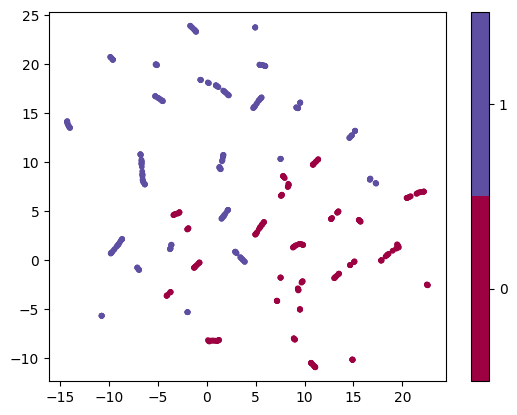

In [192]:
mapping = {label: index for index, label in enumerate(enc_cache['category'].classes_)}

plt.scatter(
    emb_umap[:, 0],
    emb_umap[:, 1],
    #c=[sns.color_palette()[x] for x in train_sc['category'].map(mapping)]
    c=train_sc['category'].map(mapping), cmap='Spectral', s=10
)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))



In [128]:
# labels = train_sc['category'].values#.tolist()
# fig = plt.figure(figsize=(20,10))
# ax  = fig.add_subplot(111, projection='3d')
# for i in range(len(labels)):
#     ax.scatter(*emb_umap.T, color='b')
#     #ax.text(emb_umap[i,0], emb_umap[i,1], emb_umap[i,2],'%s'%(str(labels[i])), size=20, zorder=1, color='k')

Text(0, 0.5, 'Component 2')

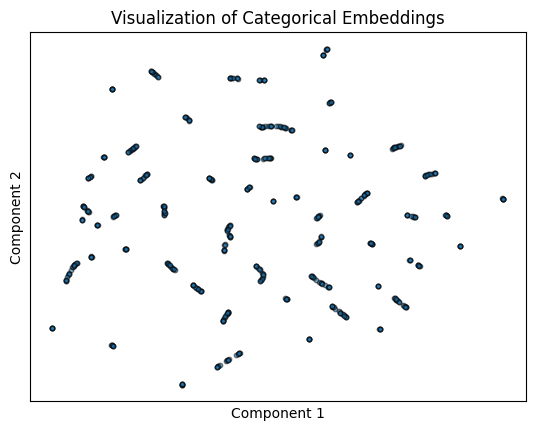

In [112]:
plt.scatter(
    *emb_umap.T,
    #emb_umap[:, 0], 
    #emb_umap[:, 1], 
    s=10, 
    alpha=0.5,
    #c=train_sc['category'].values,    # target 
    cmap=plt.cm.nipy_spectral,      # 'Spectral'
    edgecolor="k",
    label=train_sc['requested_by'].values  # target 
)
plt.setp(plt.gca(), xticks=[], yticks=[])
plt.title("Visualization of Categorical Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
# cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
# cbar.set_ticks(np.arange(10))
# cbar.set_ticklabels(classes)
#plt.colorbar(boundaries=np.arange(11) - 0.5).set_ticks(np.arange(10))

# Modeling

## Evaluation

In [2]:
def evaluate(y, yhat) -> dict:
    error     = yhat - y 
    abs_error = np.abs(error)
    sq_error  = (error)**2 
    # calculate % relateive to the actual target 
    error_rel_pct       = (error / y) * 100,
    abs_error_rel_pct   = np.abs(error_rel_pct),


# errors between prediction and true target
# df.sort_values("abs_error", ascending=False).head(5)
# error_mean, error_std = df['error'].mean(), df['eror'].std()
# plt.hist(df['error'], bins=100)
# plt.hist(df['error_rel_pct'], bins=100)

